<h3>Short introduction</h3>

Algorithm works on a bipartite graph and checks, whether the graph contains a marked vertex (or marked vertices). If there is at least one marked vertex, the final output should be 0. If there are no marked vertices, output should be 1.

<h3>Parameters</h3>

Here we provide parameters.

qubits_per_side denotes the number of qubits to represent a single vertex, a vertex is represented by a basis state. Each side of a graph can have up to $2^{qubits\_per\_side}$ vertices with this representation. Basis states in our implementation will represent edges of the graph, as a quantum walk is performed on edges. State $xxxyyy$ represents the edge, that connects vertex $xxx$ on the left side with the vertex $yyy$ on the right side of the graph.

We use a counter to perform necessary repetitions of main quantum operation. Number of repetitions is $2^{qubits\_for\_k}$. Counter uses qubits_for_k many qubits.

marked_in_A is a set of marked vertices in the left side of the graph.

marked_in_B is a set of marked vertices in the right side of the graph. We use basis state 11...1 to represent added virtual vertex that serves for initial probability distribution. For techical simplification of implementation, we denote this vertex as marked so that operator that corresponds to this vertex will be Identity, making it not affecting the walk for real edges of our graph.

edges represent all edges of our graph. $xxx111$ represent edges that correspond to initial probability distribution. The numbers that correspond to the edges are weights.

In [5]:
from math import sqrt
import numpy as np
qubits_per_side = 3
qubits_for_k = 3

marked_in_A = []
marked_in_B = ['111'] #always have 11...1 in B as marked for implementation simplification.

In [6]:
edges={
    '000111' : 1/3,
    '001111' : 2/3,
    '000000' : 1/2,
    '000001' : 1/2,
    '001000' : 1/2,
    '001001' : 1/2,
    '010000' : 1/2,
    '010001' : 1/2,
}

<h3>Preparing data structures that store lists of vertices and their adjacent edges</h3>

In [7]:
ones_state = ''
for i in range(qubits_per_side):
    ones_state = ones_state + '1'

def get_set_A():
    keysList = list(edges.keys())
    setA = []
    for i in (keysList):
        setA.append(i[:qubits_per_side])
    setA = set(setA)
    return setA

def get_set_B():
    keysList = list(edges.keys())
    setB = []
    for i in (keysList):
        setB.append(i[-qubits_per_side:])
    setB = set(setB)
    setB.remove(ones_state)
    return setB
    
setA = get_set_A()
setB = get_set_B()

In [8]:
def get_edges_of_A():
    edgesOfA = {}
    for vertex in setA:
        listOfEdges = []
        #dangling_edge = vertex + ones_state
        for edge in edges:
            if(edge[:qubits_per_side] == vertex):
                listOfEdges.append(edge)
            #if(edge == dangling_edge):
            #    listOfEdges.append(edge)
        edgesOfA.update({vertex : listOfEdges})
    return edgesOfA

edges_of_A = get_edges_of_A()

def get_edges_of_B():
    edgesOfB = {}
    for vertex in setB:
        listOfEdges = []
        for edge in edges:
            if(edge[-qubits_per_side:] == vertex):
                if(edge[:qubits_per_side] != ones_state):
                    listOfEdges.append(edge)
        edgesOfB.update({vertex : listOfEdges})
    return edgesOfB

edges_of_B = get_edges_of_B()

print('Edges adjacent to vertices of set A:',edges_of_A)
print('Edges adjacent to vertices of set B:',edges_of_B)

Edges adjacent to vertices of set A: {'010': ['010000', '010001'], '000': ['000111', '000000', '000001'], '001': ['001111', '001000', '001001']}
Edges adjacent to vertices of set B: {'000': ['000000', '001000', '010000'], '001': ['000001', '001001', '010001']}


<h3>Preparation of state $\xi$</h3>

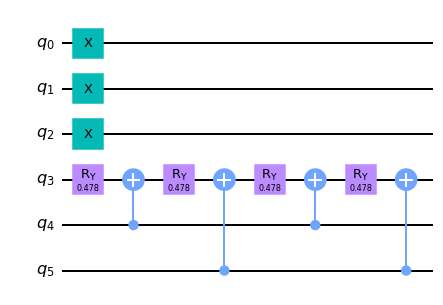

In [9]:
from math import sqrt

edges_states = {}
format_string = '0' + str(qubits_per_side) + 'b'
for i in range(2**qubits_per_side):
    edges_states.update({format(i, format_string) : 0})
for vertex in edges_of_A:
    for edge in edges_of_A[vertex]:
        if(edge[-qubits_per_side:] == ones_state):
            edges_states.update({edge[:qubits_per_side] : sqrt(edges[edge])})

desired_vector = []
for i in range(2**qubits_per_side):
    desired_vector.append(edges_states[format(i, format_string)])

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, transpile
from math import pi, sqrt
qc = QuantumCircuit(qubits_per_side)

qc.initialize(desired_vector)
qc2 = qc.decompose().decompose().decompose().decompose().decompose().decompose()
qc2 = transpile(qc2, optimization_level=1)

xi = QuantumCircuit(2*qubits_per_side)
for i in range(qubits_per_side):
    xi.x(i)
states_for_qc2 = []
for i in range(qubits_per_side):
    states_for_qc2.append(qubits_per_side+i)
xi = xi.compose(qc2,states_for_qc2)

xi.draw(output='mpl')

<h3>Circuit, that adds +1 to time register</h3>

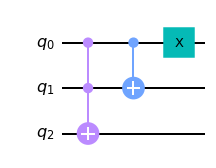

In [10]:
import qiskit

from qiskit import execute, Aer

from math import pi

plus1_adder = qiskit.QuantumCircuit(qubits_for_k)

for i in range(qubits_for_k-1,1,-1):
    control = []
    for j in range(i-1,-1,-1):
        control.append(j)
    plus1_adder.mct(control,i)
plus1_adder.cx(0,1)
plus1_adder.x(0)

plus1_adder.draw(output='mpl')

<h3>Implementation of $R_BR_A$</h3>

In [11]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from math import pi, sqrt

identity_minus_state_zero = QuantumCircuit(2*qubits_per_side)
control_qubits = []
for i in range(2*qubits_per_side-1):
    control_qubits.append(i)

for i in range(2*qubits_per_side):
    identity_minus_state_zero.x(i)

identity_minus_state_zero.h(2*qubits_per_side-1)
identity_minus_state_zero.mct(control_qubits, 2*qubits_per_side-1)
identity_minus_state_zero.h(2*qubits_per_side-1)

for i in range(2*qubits_per_side):
    identity_minus_state_zero.x(i)

r={}
format_string = '0' + str(2*qubits_per_side) + 'b'
for vertex in edges_of_A:
    total_sum = 0
    for edge in edges_of_A[vertex]:
        total_sum = total_sum + edges[edge]
    desired_vector = []
    for i in range(2**(2*qubits_per_side)):
        index = format(i, format_string)
        if index in edges_of_A[vertex]:
            desired_vector.append(sqrt(edges[index]/total_sum))
        else:
            desired_vector.append(0)
    qc = QuantumCircuit(2*qubits_per_side)
    qc.initialize(desired_vector)
    qc2 = qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose()
    qc2 = transpile(qc2, optimization_level=1)
    r[vertex] = QuantumCircuit(2*qubits_per_side)
    r[vertex] = r[vertex].compose(qc2.inverse())
    r[vertex] = r[vertex].compose(identity_minus_state_zero)
    r[vertex] = r[vertex].compose(qc2)
r_a = QuantumCircuit(2*qubits_per_side)
for vertex in edges_of_A:
    if vertex not in marked_in_A:
        r_a = r_a.compose(r[vertex])

r={}
for vertex in edges_of_B:
    total_sum = 0
    for edge in edges_of_B[vertex]:
        total_sum = total_sum + edges[edge]
    desired_vector = []
    for i in range(2**(2*qubits_per_side)):
        index = format(i, format_string)
        if index in edges_of_B[vertex]:
            desired_vector.append(sqrt(edges[index]/total_sum))
        else:
            desired_vector.append(0)
    qc = QuantumCircuit(2*qubits_per_side)
    qc.initialize(desired_vector)
    qc2 = qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose()
    qc2 = transpile(qc2, optimization_level=1)
    r[vertex] = QuantumCircuit(2*qubits_per_side)
    r[vertex] = r[vertex].compose(qc2.inverse())
    r[vertex] = r[vertex].compose(identity_minus_state_zero)
    r[vertex] = r[vertex].compose(qc2)
r_b = QuantumCircuit(2*qubits_per_side)
for vertex in edges_of_B:
    if vertex not in marked_in_B:
        r_b = r_b.compose(r[vertex])
        
rbra = r_a
rbra = rbra.compose(r_b)

<h3>Implementation of main operation</h3>

Here we implement a circuit that represents all iterations of the algorithm. In one iteration, we apply R_B R_A and operator that increases counter by +1. In total there are $2^{qubits\_for\_k}$ iterations.

In [12]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, transpile
from math import pi, sqrt
algorithm_circuit = QuantumCircuit(qubits_for_k+2*qubits_per_side)

plus1_adder_qubits = []
for i in range(qubits_per_side):
    plus1_adder_qubits.append(i)
for i in range(qubits_for_k):
    plus1_adder_qubits.append(2*qubits_per_side+i)

for i in range(2**qubits_for_k):
    algorithm_circuit = algorithm_circuit.compose(rbra)
    algorithm_circuit = algorithm_circuit.compose(plus1_adder.control(3), plus1_adder_qubits)

<h3>Initial state of the system</h3>

Here we initialize state for edges of the graph and also intialize counter in a superposition.

In [13]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, transpile
from math import pi, sqrt
initial_state = QuantumCircuit(qubits_for_k+2*qubits_per_side)

for i in range(qubits_for_k):
    initial_state.h(2*qubits_per_side+i)
initial_state = initial_state.compose(xi)

<h3>Final circuit</h3>

We add a qubit and perform small version of Phase estimation to distinguish between states $\xi$ and $-\xi$.

{'1': 3684, '0': 6316}


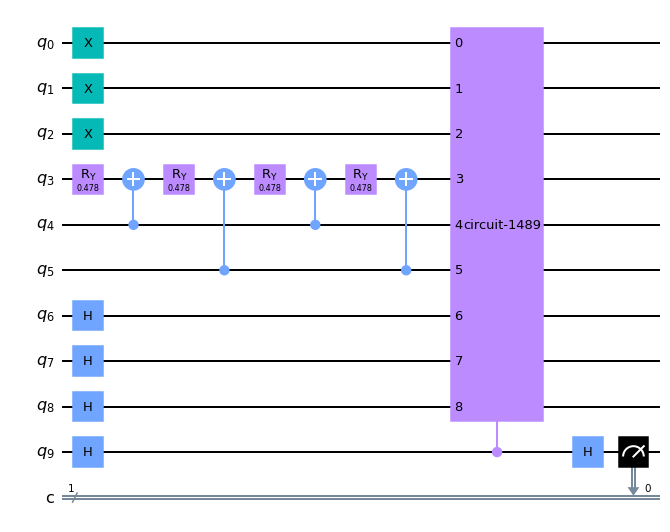

In [14]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, transpile
from math import pi, sqrt
final_circuit = QuantumCircuit(qubits_for_k+2*qubits_per_side+1,1)

final_circuit = final_circuit.compose(initial_state)
final_circuit.h(qubits_for_k+2*qubits_per_side)

qubits_for_algorithm = []
qubits_for_algorithm.append(qubits_for_k+2*qubits_per_side)
for i in range(qubits_for_k+2*qubits_per_side):
    qubits_for_algorithm.append(i)
    
final_circuit = final_circuit.compose(algorithm_circuit.control(1), qubits_for_algorithm)

final_circuit.h(qubits_for_k+2*qubits_per_side)

final_circuit.measure(qubits_for_k+2*qubits_per_side, 0)

job = execute(final_circuit,Aer.get_backend('qasm_simulator'),shots=10000)
counts = job.result().get_counts(final_circuit)
print(counts)

final_circuit.draw(output='mpl')